In [6]:
import torch
import numpy as np
import torch.nn as nn

import os
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [7]:
def get_rays(datapath, mode="train"):

    datapath = f"/content/drive/MyDrive/ColabNotebooks/NeRF/{datapath}"

    pose_file_names = [f for f in os.listdir(datapath + f'/{mode}/pose') if f.endswith('.txt')]
    intrisics_file_names = [f for f in os.listdir(datapath + f'/{mode}/intrinsics') if f.endswith('.txt')]
    img_file_names = [f for f in os.listdir(datapath + '/imgs') if mode in f]

    assert len(pose_file_names) == len(intrisics_file_names)
    assert len(img_file_names) == len(pose_file_names)

    # Read
    N = len(pose_file_names)
    poses = np.zeros((N, 4, 4))
    intrinsics = np.zeros((N, 4, 4))

    images = []

    for i in range(N):
        name = pose_file_names[i]

        pose = open(datapath + f'/{mode}/pose/' + name).read().split()
        poses[i] = np.array(pose, dtype=float).reshape(4, 4)

        intrinsic = open(datapath + f'/{mode}/intrinsics/' + name).read().split()
        intrinsics[i] = np.array(intrinsic, dtype=float).reshape(4, 4)

        # Read images
        img = imageio.imread(datapath + '/imgs/' + name.replace('txt', 'png')) / 255.
        images.append(img[None, ...])
    images = np.concatenate(images)

    H = images.shape[1]
    W = images.shape[2]

    if images.shape[3] == 4: #RGBA -> RGB
        images = images[..., :3] * images[..., -1:] + (1 - images[..., -1:])

    rays_o = np.zeros((N, H*W, 3))
    rays_d = np.zeros((N, H*W, 3))
    target_px_values = images.reshape((N, H*W, 3))

    for i in range(N):

        c2w = poses[i]
        f = intrinsics[i, 0, 0]

        u = np.arange(W)
        v = np.arange(H)
        u, v = np.meshgrid(u, v)
        dirs = np.stack((u - W / 2, -(v - H / 2), - np.ones_like(u) * f), axis=-1)
        dirs = (c2w[:3, :3] @ dirs[..., None]).squeeze(-1)
        dirs = dirs / np.linalg.norm(dirs, axis=-1, keepdims=True)

        rays_d[i] = dirs.reshape(-1, 3)
        rays_o[i] += c2w[:3, 3]

    return rays_o, rays_d, target_px_values

In [8]:
def compute_accumulated_transmittance(betas):
    accumulated_transmittance = torch.cumprod(betas, 1)
    return torch.cat((torch.ones(accumulated_transmittance.shape[0], 1, device=accumulated_transmittance.device),
                      accumulated_transmittance[:, :-1]), dim=1)

def rendering(model, rays_o, rays_d, tn, tf, nb_bins=100, device='cpu', white_bckgr=True):

    t = torch.linspace(tn, tf, nb_bins).to(device) # [nb_bins]
    delta = torch.cat((t[1:] - t[:-1], torch.tensor([1e10], device=device)))

    x = rays_o.unsqueeze(1) + t.unsqueeze(0).unsqueeze(-1) * rays_d.unsqueeze(1) # [nb_rays, nb_bins, 3]

    colors, density = model.intersect(x.reshape(-1, 3), rays_d.expand(x.shape[1], x.shape[0], 3).transpose(0, 1).reshape(-1, 3))

    colors = colors.reshape((x.shape[0], nb_bins, 3)) # [nb_rays, nb_bins, 3]
    density = density.reshape((x.shape[0], nb_bins))

    alpha = 1 - torch.exp(- density * delta.unsqueeze(0)) # [nb_rays, nb_bins, 1]

    weights = compute_accumulated_transmittance(1 - alpha) * alpha # [nb_rays, nb_bins]

    if white_bckgr:
        c = (weights.unsqueeze(-1) * colors).sum(1) # [nb_rays, 3]
        weight_sum = weights.sum(-1) # [nb_rays]
        return c + 1 - weight_sum.unsqueeze(-1)
    else:
        c = (weights.unsqueeze(-1) * colors).sum(1) # [nb_rays, 3]

    return c

In [9]:
class Nerf(nn.Module):

    def __init__(self, Lpos=10, Ldir=4, hidden_dim=256):
        super(Nerf, self).__init__()

        self.block1 = nn.Sequential(nn.Linear(Lpos * 6 + 3, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU())

        self.block2 = nn.Sequential(nn.Linear(hidden_dim + Lpos * 6 + 3, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim + 1),)

        self.rgb_head = nn.Sequential(nn.Linear(hidden_dim + Ldir * 6 + 3, hidden_dim // 2), nn.ReLU(),
                                      nn.Linear(hidden_dim // 2, 3), nn.Sigmoid())

        self.Lpos = Lpos
        self.Ldir = Ldir

    def positional_encoding(self, x, L):
        out = [x]
        for j in range(L):
            out.append(torch.sin(2 ** j * x))
            out.append(torch.cos(2 ** j * x))
        return torch.cat(out, dim=1)



    def forward(self, xyz, d):

        x_emb = self.positional_encoding(xyz, self.Lpos) # [batch_size, Lpos * 6 + 3]
        d_emb = self.positional_encoding(d, self.Ldir) # [batch_size, Ldir * 6 + 3]

        h = self.block1(x_emb) # [batch_size, hidden_dim]
        h = self.block2(torch.cat((h, x_emb), dim=1)) # [batch_size, hidden_dim + 1]
        sigma = h[:, -1]
        h = h[:, :-1] # [batch_size, hidden_dim]
        c = self.rgb_head(torch.cat((h, d_emb), dim=1))

        return c, torch.relu(sigma)


    def intersect(self, x, d):
        return self.forward(x, d)

# Camera / Dataset

In [10]:
batch_size = 1024

o, d, target_px_values = get_rays("fox", mode="train")
dataloader = DataLoader(torch.cat((torch.from_numpy(o).reshape(-1, 3).type(torch.float),
                                   torch.from_numpy(d).reshape(-1, 3).type(torch.float),
                                   torch.from_numpy(target_px_values).reshape(-1, 3).type(torch.float)), dim=1),
                        batch_size=batch_size, shuffle=True)

dataloader_warmup = DataLoader(torch.cat((torch.from_numpy(o).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3).type(torch.float),
                               torch.from_numpy(d).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3).type(torch.float),
                               torch.from_numpy(target_px_values).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3).type(torch.float)), dim=1),
                       batch_size=batch_size, shuffle=True)

test_o, test_d, test_target_px_values = get_rays("fox", mode="test")

<ipython-input-7-5bf22eb51a89>:29: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(datapath + '/imgs/' + name.replace('txt', 'png')) / 255.


# Model

In [11]:
# model = Voxels(scale=3.)

# Training

In [12]:
from tqdm import tqdm

def training(model, optimizer, scheduler, tn, tf, nb_bins, nb_epochs, data_loader, device="cpu"):

  training_loss = []
  for epoch in tqdm(range(nb_epochs)):
    for batch in tqdm(data_loader):
      o = batch[:, :3].to(device).float()
      d = batch[:, 3:6].to(device).float()
      target= batch[:, 6:].to(device).float()

      prediction = rendering(model, o, d, tn, tf, nb_bins=nb_bins, device=device)

      loss = ((prediction - target)**2).mean()

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      training_loss.append(loss.item())

    scheduler.step()
    torch.save(model.cpu(), "/content/drive/MyDrive/ColabNotebooks/NeRF/model_nerf")
    model.to(device)
  return training_loss

In [ ]:
device = "cuda"

tn = 8.
tf = 12.
nb_epochs = 10
lr = 1e-3
gamma = 0.5
nb_bins = 100

model = Nerf(hidden_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10], gamma=gamma)

training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, 1, dataloader_warmup, device=device)
# plt.plot(training_loss)
# plt.show()
training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, nb_epochs, dataloader, device=device)

Streaming output truncated to the last 5000 lines.
100%|██████████| 10/10 [2:03:17<00:00, 739.71s/it]


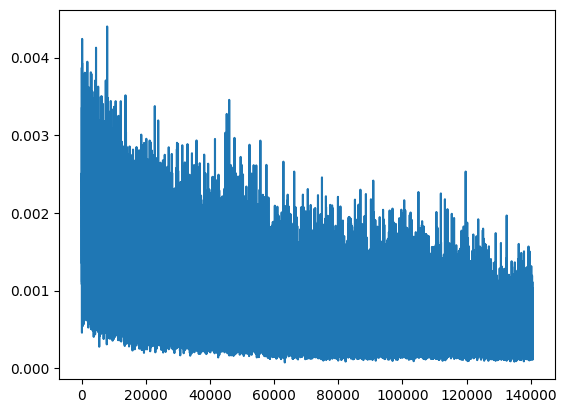

In [ ]:
plt.plot(training_loss)

In [ ]:
torch.save(model, "/content/drive/MyDrive/ColabNotebooks/NeRF/model_nerf")